# Aprendizaje desbalanceado

Hasta ahora, todos los conjuntos de datos que hemos procesado y utilizado para entrenar modelos de clasificación estaban **equilibrados**, es decir, **tenían un número similar de observaciones para cada una de las etiquetas del problema**. Esto ha resultado ser muy conveniente, ya que los modelos de clasificación que hemos estudiado funcionan mejor cuanto más equilibrado es el conjunto de datos de entrenamiento.

Sin embargo, encontrar conjuntos de datos desequilibrados es más frecuente de lo que parece cuando trabajamos con información obtenida del mundo real. Vamos a estudiar **diferentes técnicas para mitigar el problema de tener un conjunto de datos desequilibrado con respecto a las clases**.

## Un dataset desequilibrado

Para analizar diferentes técnicas de aprendizaje de problemas de desequilibrio vamos a utilizar un conjunto de datos alojado en [Kaggle](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction). Este *dataset* recoge **más de 50 características** relacionadas con el historial de clientes de una aseguradora de coches brasileña. Según la descripción del conjunto de datos:

> In the training and test data, features belonging to similar groups are labeled as such in the feature names (e.g., `ind`, `reg`, `car`, `calc`). In addition, feature names include the prefix `bin` to indicate binary features and `cat` to indicate categorical features. Attributes without these designations are continuous or ordinal. Values of $-1$ indicate that the attribute was missing from the observation. The target column signifies whether or not a claim was filed for that policyholder.





In [1]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 189 kB 2.3 MB/s eta 0:00:01     |████████▋                       | 51 kB 2.0 MB/s eta 0:00:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.7.0
    Uninstalling imbalanced-learn-0.7.0:
      Successfully uninstalled imbalanced-learn-0.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.3.4 requires imbalanced-learn==0.7.0, but you have imbalanced-learn 0.8.1 which is incompatible.
pycaret 2.3.4 requires scikit-learn==0.23.2, but you have scikit-learn 1.0 which is incompatible.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 100 MB dataset... please, be patient
raw_data = pd.read_csv('https://drive.upm.es/index.php/s/F6OxUlDc5nV9870/download')

Class 0: 573518
Class 1: 21694
Proportion: 26.44 : 1


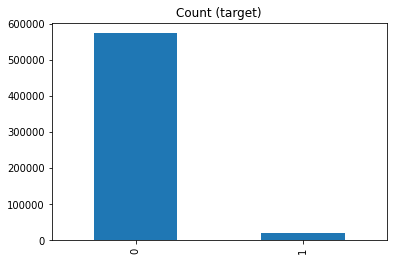

In [3]:
# Split the dataset into features X and target Y
X = raw_data.iloc[:,2:]
Y = raw_data['target']

target_count = Y.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Como podemos ver en la figura, la distribución de las etiquetas no está en absoluto equilibrada. Por cada observación con **etiqueta 1** tenemos **26 observaciones con etiqueta 0**. Es evidente que estamos ante un problema de desequilibrio.

## El problema de las métricas optimistas

Veamos por qué es importante utilizar las métricas adecuadas cuando evaluamos el rendimiento de un estimador.

Supongamos que, como primera aproximación, vamos a entrenar un modelo **Random Forest**. Como ya sabemos, es un modelo sin distribución, por lo que no necesitamos preprocesar el *conjunto de datos* para estandarizar los valores de los atributos.

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

clf = RandomForestClassifier(n_jobs=-1)

clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [6]:
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.36%


El uso de métricas simples como `accuracy_score` puede ser engañoso. En un conjunto de datos con clases muy desequilibradas, si el clasificador **siempre predice la clase más común** sin realizar ningún análisis de características, seguirá teniendo una puntuación de precisión obviamente ilusoria.

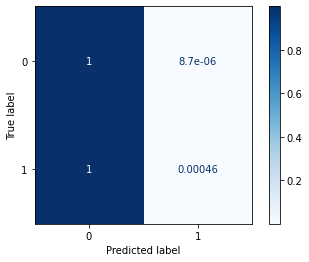

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap='Blues', normalize='true')

Al representar la matriz de confusión del modelo, observamos que **apenas** predijo con éxito una **etiqueta 1**. Este era el comportamiento esperado. Ahora tenemos que considerar qué técnicas podemos utilizar para mejorar estos resultados de forma que el clasificador no tenga un buen rendimiento por estar limitado a predecir sólo la clase mayoritaria.

## Resampling

Una de las técnicas más sencillas que pueden utilizarse para mitigar los efectos de un conjunto desequilibrado es el **resampling**. Dentro del **resampling** distinguiremos dos enfoques:

* Undersampling
* Oversampling

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

### Undersampling

El concepto de esta técnica es muy sencillo: **eliminar muestras seleccionadas al azar de la clase predominante** para equilibrar el conjunto de datos. Obviamente, esta técnica provoca una pérdida de información que dependerá del ratio de desequilibrio que exista entre las clases, cuanto mayor sea el ratio, mayor será la pérdida de información.

Vamos a ver cómo podemos realizar un **submuestreo aleatorio** combinando *scikit-learn* con una librería de Python específica para datos desequilibrados llamada [Imbalanced Learning](https://imbalanced-learn.readthedocs.io).


In [9]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()

X_rus, y_rus = rus.fit_resample(X_train, y_train)

Ahora hemos construido un conjunto de datos con clases equilibradas eliminando algunas muestras de la clase mayoritaria:

Class 0: 17355
Class 1: 17355
Proportion: 1.0 : 1


<AxesSubplot:title={'center':'Count (target)'}>

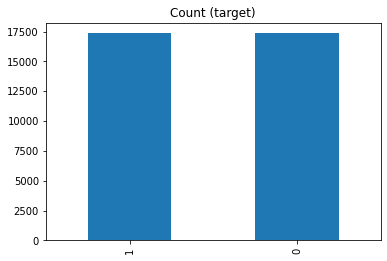

In [10]:
target_count = pd.Series(y_rus).value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

Veamos cómo se comporta el clasificador cuando lo entrenamos con este conjunto de datos ya equilibrado:

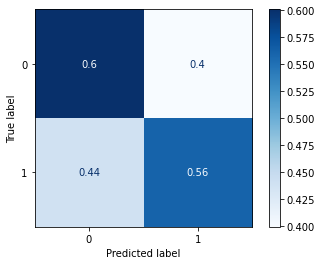

In [11]:
clf_rus = RandomForestClassifier(n_jobs=-1)

clf_rus.fit(X_rus, y_rus)

ConfusionMatrixDisplay.from_estimator(clf_rus, X_test, y_test, cmap='Blues', normalize='true')

Hemos mejorado bastante la tasa de aciertos de la **clase 1**, aunque está lejos de ser una buena tasa. Era de esperar, ya que hemos perdido mucha información al realizar el **submuestreo**, como también se refleja en el descenso de la precisión de la **clase 0**.

### Under-sampling: Tomek links

Los enlaces Tomek son pares de instancias muy cercanas, pero de clases opuestas. La eliminación de instancias de la clase mayoritaria de cada par aumenta el espacio entre las dos clases, facilitando el proceso de clasificación.

![](https://st2.ning.com/topology/rest/1.0/file/get/2808332936?profile=original)


Class 0: 453611
Class 1: 17355
Proportion: 26.14 : 1


<AxesSubplot:title={'center':'Count (target)'}>

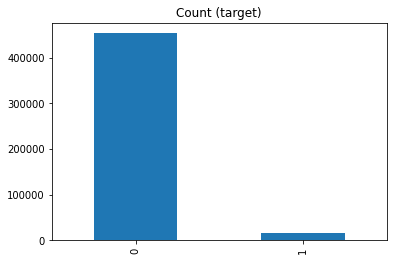

In [13]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='auto', n_jobs=-1)
X_tl, y_tl = tl.fit_resample(X_train, y_train)

target_count = pd.Series(y_tl).value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

Podemos observar que, a pesar de haber eliminado los enlaces Tomek, no hemos reducido casi el desequilibrio en el conjunto de datos, por lo que cabe esperar que el modelo siga funcionando mal:

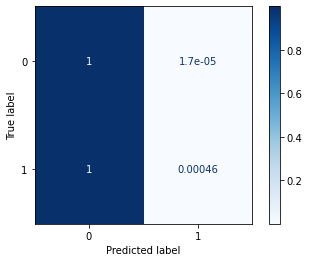

In [16]:
clf_tomek = RandomForestClassifier(n_jobs=-1)

clf_tomek.fit(X_tl, y_tl)
ConfusionMatrixDisplay.from_estimator(clf_tomek, X_test, y_test, cmap='Blues', normalize='true')

### Under-sampling: cluster centroids

Esta técnica consiste en calcular los centroides de los clusters de las observaciones de la clase mayoritaria. Las observaciones que pertenecen al mismo clúster se eliminan del conjunto de datos y todas se sustituyen por una única observación que es el centroide del clúster.

Jugando con el parámetro `sampling_strategy` podemos especificar la relación interclase deseada para el nuevo conjunto de datos:

Class 0: 43387
Class 1: 17355
Proportion: 2.5 : 1


<AxesSubplot:title={'center':'Count (target)'}>

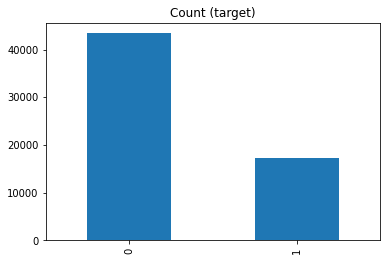

In [7]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy=0.4)
X_cc, y_cc = cc.fit_resample(X_train, y_train)

target_count = pd.Series(y_cc).value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

Ajustamos un clasificador utilizando el nuevo conjunto de datos equilibrado:

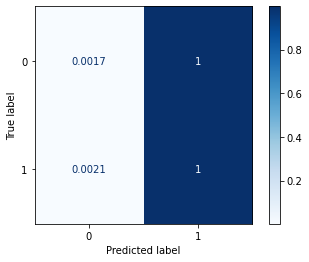

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

clf_cc = RandomForestClassifier(n_jobs=-1)

clf_cc.fit(X_cc, y_cc)
ConfusionMatrixDisplay.from_estimator(clf_cc, X_test, y_test, normalize='true', cmap='Blues')

### Random oversampling

De forma análoga al **submuestreo**, esta técnica duplica las observaciones de la clase minoritaria tantas veces como sea necesario para alcanzar un equilibrio en la distribución de las clases:

Class 0: 458814
Class 1: 458814
Proportion: 1.0 : 1


<AxesSubplot:title={'center':'Count (target)'}>

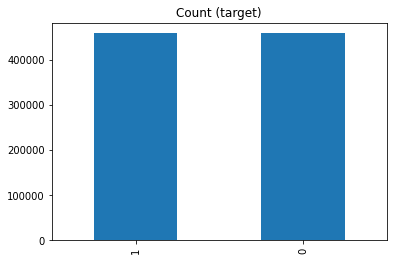

In [10]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)

target_count = pd.Series(y_ros).value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

Calculamos la matriz de confusión de **Random Forest** entrenando el modelo con el conjunto de datos equilibrado que hemos obtenido aplicando un **sobremuestreo aleatorio**:

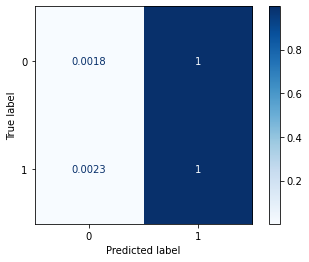

In [12]:
clf_ros = RandomForestClassifier(n_jobs=-1)

clf_ros.fit(X_cc, y_cc)
ConfusionMatrixDisplay.from_estimator(clf_ros, X_test, y_test, normalize='true', cmap='Blues')

### Over-sampling: SMOTE

**SMOTE (Synthetic Minority Oversampling TEchnique)** es una técnica que consiste en crear observaciones sintéticas para la clase minoritaria, a partir de las que ya existen. Funciona eligiendo aleatoriamente un punto de la clase minoritaria y calculando los vecinos más cercanos para este punto. Los puntos sintéticos se añaden entre el punto elegido y sus vecinos.

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

Class 0: 458814
Class 1: 458814
Proportion: 1.0 : 1


<AxesSubplot:title={'center':'Count (target)'}>

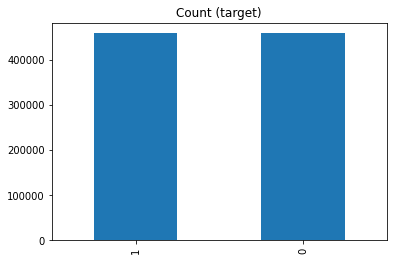

In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

target_count = pd.Series(y_sm).value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

Evaluamos el rendimiento del modelo una vez realizado el **sobremuestreo SMOTE**:

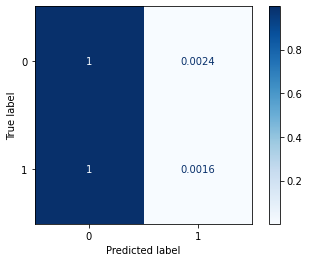

In [14]:
clf_sm = RandomForestClassifier(n_jobs=-1)

clf_sm.fit(X_sm, y_sm)
ConfusionMatrixDisplay.from_estimator(clf_sm, X_test, y_test, normalize='true', cmap='Blues')

---

Creado por **Raúl Lara Cabrera** (raul.lara@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">